# 3.5 뉴스 기사 분류: 다중 분류 문제
- 로이터 뉴스를 46개 토픽으로 분류
- **다중 분류**(multiclass classification) 문제 / **단일 레이블 다중 분류**(single-label, multiclass classification)
    - 각 데이터가 여러 범주에 들어간다면 **다중 레이블 다중 분류**(multi-label, multiclass classification)

## 3.5.1 로이터 데이터셋
- 1986년 로이터 뉴스 기사
- 46개 토픽, 각 최소 10개의 샘플

In [1]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


In [2]:
len(train_data), len(test_data)

(8982, 2246)

In [3]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


### 로이터 데이터셋을 텍스트로 디코딩하기

In [4]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

565248/550378 [==============================] - 0s 0us/step


In [5]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## 3.5.2 데이터 준비
- 데이터 벡터로 변환
- 레이블 원-핫 인코딩 (**범주형 인코딩**(categorical encoding)이라고도 함)

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [7]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [8]:
x_train.shape, one_hot_train_labels.shape

((8982, 10000), (8982, 46))

In [ ]:
# from tensorflow.keras.utils import to_categorical

# one_hot_train_labels = to_categorical(train_labels)
# one_hot_test_labels = to_categorical(test_labels)

## 3.5.3 모델 구성
- 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있기 때문에 일부 정보를 누락하면 그 다음 층에서 복원할 방법이 없음 (잠재적으로 정보의 병목(information bottleneck))
- 그러므로 영화 이진 분류의 16개 유닛에서 64개 유닛으로 규모를 키움

### 모델 정의
- 마지막 `Dense` 층의 크기 46 = 각 입력 샘플에 대해서 46차원의 벡터를 출력
- 마지막 층 `softmax` 활성화 함수 = 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

### 모델 컴파일
- 최선의 손실 함수 : `categorical_crossentropy`로 두 확률 분포 사이의 거리를 측정

In [10]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## 3.5.4 훈련 검증

### 검증 세트 준비하기
- 1000개 데이터를 검증 세트로 사용

In [11]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

### 모델 훈련

In [13]:
history = model.fit(partial_x_train, partial_y_train,
                   epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 23ms/step - loss: 2.5166 - accuracy: 0.5370 - val_loss: 1.6661 - val_accuracy: 0.6480
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 1.3535 - accuracy: 0.7164 - val_loss: 1.2852 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 1.0158 - accuracy: 0.7858 - val_loss: 1.1322 - val_accuracy: 0.7500
Epoch 4/20
16/16 [==============================] - 0s 12ms/step - loss: 0.7971 - accuracy: 0.8321 - val_loss: 1.0432 - val_accuracy: 0.7880
Epoch 5/20
16/16 [==============================] - 0s 12ms/step - loss: 0.6445 - accuracy: 0.8672 - val_loss: 1.0067 - val_accuracy: 0.7920
Epoch 6/20
16/16 [==============================] - 0s 12ms/step - loss: 0.5161 - accuracy: 0.8945 - val_loss: 0.9569 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 0s 12ms/step - loss: 0.4209 - accuracy: 0.9124 - val_loss: 0.9305 - val_accuracy: 0.8130
Epoch 8/20
16

### 훈련과 검증 손실 그리기

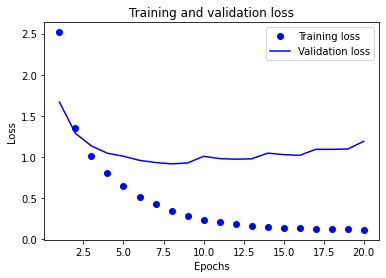

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 훈련과 검증 정확도 그리기

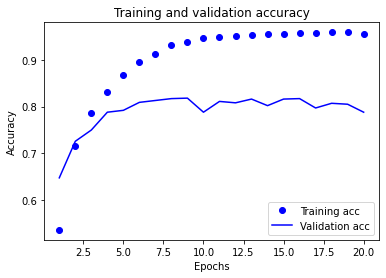

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델을 처음부터 다시 훈련하기
- 9번째부터 과적합

In [16]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 20ms/step - loss: 2.7630 - accuracy: 0.4994 - val_loss: 1.8217 - val_accuracy: 0.6500
Epoch 2/9
16/16 [==============================] - 0s 12ms/step - loss: 1.4503 - accuracy: 0.7086 - val_loss: 1.3092 - val_accuracy: 0.7240
Epoch 3/9
16/16 [==============================] - 0s 11ms/step - loss: 1.0352 - accuracy: 0.7809 - val_loss: 1.1206 - val_accuracy: 0.7700
Epoch 4/9
16/16 [==============================] - 0s 12ms/step - loss: 0.8044 - accuracy: 0.8334 - val_loss: 1.0089 - val_accuracy: 0.7930
Epoch 5/9
16/16 [==============================] - 0s 12ms/step - loss: 0.6339 - accuracy: 0.8711 - val_loss: 0.9492 - val_accuracy: 0.8110
Epoch 6/9
16/16 [==============================] - 0s 11ms/step - loss: 0.5026 - accuracy: 0.8963 - val_loss: 0.9408 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 0s 12ms/step - loss: 0.4073 - accuracy: 0.9142 - val_loss: 0.9344 - val_accuracy: 0.8010
Epoch 8/9
16/16 [===

In [17]:
results

[0.9745821952819824, 0.7943009734153748]

#### 정확도 해석
- 무작위 분류 시 18% 정도이므로, 79%면 좋은 편

In [18]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1829919857524488

## 3.5.5 새로운 데이터에 대해 예측하기

In [19]:
predictions = model.predict(x_test)

In [20]:
# 각 항목은 길이가 46인 벡터
predictions.shape

(2246, 46)

In [21]:
# 벡터 원소 합 = 1
np.sum(predictions[0])

1.0

In [22]:
# 가장 큰 값이 예측 클래스
np.argmax(predictions[0])

3

## 3.5.6 레이블과 손실을 다루는 다른 방법
- 정수 텐서로 변환했을 때 loss에 `sparse_categorical_crossentropy` 사용

```python
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
```

## 3.5.7 충분히 큰 중간층을 두어야 하는 이유
- 정보의 병목
- 정확도가 79%에서 62%로 17%나 감소
- 많은 정보(46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축했기 때문에 발생

In [24]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 20ms/step - loss: 3.6010 - accuracy: 0.0737 - val_loss: 3.3654 - val_accuracy: 0.0600
Epoch 2/9
16/16 [==============================] - 0s 12ms/step - loss: 3.1170 - accuracy: 0.1040 - val_loss: 2.9151 - val_accuracy: 0.3930
Epoch 3/9
16/16 [==============================] - 0s 12ms/step - loss: 2.6337 - accuracy: 0.4116 - val_loss: 2.4917 - val_accuracy: 0.3940
Epoch 4/9
16/16 [==============================] - 0s 12ms/step - loss: 2.1984 - accuracy: 0.4057 - val_loss: 2.1354 - val_accuracy: 0.3880
Epoch 5/9
16/16 [==============================] - 0s 12ms/step - loss: 1.8447 - accuracy: 0.5276 - val_loss: 1.8580 - val_accuracy: 0.5610
Epoch 6/9
16/16 [==============================] - 0s 12ms/step - loss: 1.5678 - accuracy: 0.6298 - val_loss: 1.6651 - val_accuracy: 0.6060
Epoch 7/9
16/16 [==============================] - 0s 11ms/step - loss: 1.3779 - accuracy: 0.6602 - val_loss: 1.5466 - val_accuracy: 0.6190
Epoch 8/9
16/16 [===

In [25]:
results

[1.4844651222229004, 0.6268922686576843]

## 3.5.8 추가 실험

### 1. 더 크거나 작은 층 사용

#### 32개의 유닛
- 77%

In [26]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 19ms/step - loss: 2.8914 - accuracy: 0.5013 - val_loss: 2.1186 - val_accuracy: 0.5920
Epoch 2/9
16/16 [==============================] - 0s 12ms/step - loss: 1.7490 - accuracy: 0.6619 - val_loss: 1.5586 - val_accuracy: 0.6690
Epoch 3/9
16/16 [==============================] - 0s 11ms/step - loss: 1.3147 - accuracy: 0.7254 - val_loss: 1.3294 - val_accuracy: 0.7060
Epoch 4/9
16/16 [==============================] - 0s 11ms/step - loss: 1.0815 - accuracy: 0.7685 - val_loss: 1.2016 - val_accuracy: 0.7440
Epoch 5/9
16/16 [==============================] - 0s 11ms/step - loss: 0.9226 - accuracy: 0.8003 - val_loss: 1.1268 - val_accuracy: 0.7520
Epoch 6/9
16/16 [==============================] - 0s 11ms/step - loss: 0.7941 - accuracy: 0.8266 - val_loss: 1.0594 - val_accuracy: 0.7810
Epoch 7/9
16/16 [==============================] - 0s 12ms/step - loss: 0.6871 - accuracy: 0.8497 - val_loss: 1.0088 - val_accuracy: 0.7890
Epoch 8/9
16/16 [===

#### 128개의 유닛
- 77% (훈련 세트 정확도는 매우 높음)

In [27]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 20ms/step - loss: 2.1609 - accuracy: 0.5517 - val_loss: 1.3857 - val_accuracy: 0.6820
Epoch 2/9
16/16 [==============================] - 0s 13ms/step - loss: 1.1075 - accuracy: 0.7571 - val_loss: 1.1085 - val_accuracy: 0.7580
Epoch 3/9
16/16 [==============================] - 0s 12ms/step - loss: 0.7986 - accuracy: 0.8269 - val_loss: 0.9974 - val_accuracy: 0.7940
Epoch 4/9
16/16 [==============================] - 0s 12ms/step - loss: 0.5647 - accuracy: 0.8806 - val_loss: 1.1008 - val_accuracy: 0.7420
Epoch 5/9
16/16 [==============================] - 0s 12ms/step - loss: 0.4310 - accuracy: 0.9083 - val_loss: 0.8940 - val_accuracy: 0.8080
Epoch 6/9
16/16 [==============================] - 0s 13ms/step - loss: 0.3175 - accuracy: 0.9316 - val_loss: 1.0179 - val_accuracy: 0.7750
Epoch 7/9
16/16 [==============================] - 0s 13ms/step - loss: 0.2604 - accuracy: 0.9410 - val_loss: 0.9394 - val_accuracy: 0.8050
Epoch 8/9
16/16 [===

### 2. 1개 또는 3개의 은닉 층 사용

#### 1개의 은닉 층
- 79%

In [29]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 19ms/step - loss: 2.5875 - accuracy: 0.5616 - val_loss: 1.8367 - val_accuracy: 0.6540
Epoch 2/9
16/16 [==============================] - 0s 11ms/step - loss: 1.4900 - accuracy: 0.7141 - val_loss: 1.3570 - val_accuracy: 0.7150
Epoch 3/9
16/16 [==============================] - 0s 11ms/step - loss: 1.0767 - accuracy: 0.7848 - val_loss: 1.1426 - val_accuracy: 0.7590
Epoch 4/9
16/16 [==============================] - 0s 11ms/step - loss: 0.8377 - accuracy: 0.8320 - val_loss: 1.0114 - val_accuracy: 0.7950
Epoch 5/9
16/16 [==============================] - 0s 11ms/step - loss: 0.6717 - accuracy: 0.8690 - val_loss: 0.9433 - val_accuracy: 0.8080
Epoch 6/9
16/16 [==============================] - 0s 11ms/step - loss: 0.5475 - accuracy: 0.8931 - val_loss: 0.8843 - val_accuracy: 0.8150
Epoch 7/9
16/16 [==============================] - 0s 11ms/step - loss: 0.4525 - accuracy: 0.9079 - val_loss: 0.8572 - val_accuracy: 0.8210
Epoch 8/9
16/16 [===

#### 3개의 은닉 층
- 78%

In [30]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                   epochs=9, batch_size=512, validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 20ms/step - loss: 2.7270 - accuracy: 0.4119 - val_loss: 1.7952 - val_accuracy: 0.5860
Epoch 2/9
16/16 [==============================] - 0s 12ms/step - loss: 1.4676 - accuracy: 0.6868 - val_loss: 1.3225 - val_accuracy: 0.7030
Epoch 3/9
16/16 [==============================] - 0s 12ms/step - loss: 1.0981 - accuracy: 0.7578 - val_loss: 1.1635 - val_accuracy: 0.7420
Epoch 4/9
16/16 [==============================] - 0s 12ms/step - loss: 0.8809 - accuracy: 0.8038 - val_loss: 1.0826 - val_accuracy: 0.7690
Epoch 5/9
16/16 [==============================] - 0s 12ms/step - loss: 0.7051 - accuracy: 0.8497 - val_loss: 1.0201 - val_accuracy: 0.7870
Epoch 6/9
16/16 [==============================] - 0s 12ms/step - loss: 0.5642 - accuracy: 0.8751 - val_loss: 1.0697 - val_accuracy: 0.7850
Epoch 7/9
16/16 [==============================] - 0s 13ms/step - loss: 0.4550 - accuracy: 0.8981 - val_loss: 0.9826 - val_accuracy: 0.8030
Epoch 8/9
16/16 [===